#                                                                           Harris Corner Detection


In [94]:
import cv2
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import convolve


# Gaussian Function

In [95]:
def gaus(size, sigma):
    center = size // 2
    gaussian = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            gaussian[i, j] = np.exp(-((x ** 2 + y ** 2) / (2 * sigma ** 2)))

    # Normalize the Gaussian kernel
    gaussian /= np.sum(gaussian)
    return gaussian

# Gradients

In [96]:
def compute_gradients(image):
     I_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in X direction
     I_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in Y direction

     return I_x, I_y

# Structure Tensor

In [97]:
def compute_structure_tensor(I_x_smooth, I_y_smooth):
    I_x2 = I_x_smooth ** 2
    I_y2 = I_y_smooth ** 2
    I_xy = I_x_smooth * I_y_smooth
    return I_x2, I_y2, I_xy

# Applying Window

In [98]:
def apply_window(I_x2, I_y2, I_xy, size, sigma):
    gaussian_kernel = gaus(size, sigma)  # Create custom Gaussian kernel
    w_x2 = convolve(I_x2, gaussian_kernel)
    w_y2 = convolve(I_y2, gaussian_kernel)
    w_xy = convolve(I_xy, gaussian_kernel)
    return w_x2, w_y2, w_xy

# Corner Response

In [99]:
def compute_corner_response(w_x2, w_y2, w_xy, k):
    det_M = w_x2 * w_y2 - w_xy**2
    trace_M = w_x2 + w_y2
    R = det_M - k * (trace_M**2)
    return R

# Thresholding

In [100]:
def apply_threshold(R, threshold_ratio):
    R_max = np.max(R)
    threshold = threshold_ratio * R_max
    R[R < threshold] = 0
    return R

# Non maxima supression

In [101]:
def non_max_suppression(R, window_size=7):
    
    suppressed_R = np.zeros_like(R)
    
    for i in range(window_size, R.shape[0] - window_size):
        for j in range(window_size, R.shape[1] - window_size):
            window = R[i-window_size:i+window_size+1, j-window_size:j+window_size+1]
            if R[i, j] == np.max(window):
                suppressed_R[i, j] = R[i, j]
    
    return suppressed_R

# Corner Plotting

In [102]:
def plot_image_with_corners(image, corners, output_path):

    # Get the original image dimensions
    height, width = image.shape[:2]
    
    # Calculate figsize in inches based on the image size and DPI
    dpi = 100  # Dots per inch
    figsize = (width / dpi, height / dpi)
    
    # Create a figure with the size of the original image
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Plot the image
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)  # Use grayscale colormap if image is grayscale
    
    # Overlay red plus signs on the corner locations
    y_coords, x_coords = corners[:, 0], corners[:, 1]
    plt.scatter(x_coords, y_coords, c='red', s=50, marker='+')  # 's' is the size of the marker
    
    # Customize and display the plot
    plt.axis('off')  # Hide axis
    # plt.title('Image with Detected Corners')  # Title line is commented out
    
    # Save the image with the same dimensions as the original
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=1.5*dpi)
    plt.close()


# Harris Corner Responce

In [103]:
def harris_corner_detection(image, k=0.06, threshold_ratio=0.01, size=5, sigma=1):
    # Step 1: Load the original image and convert to grayscale
    # The original image is loaded and converted to grayscale to simplify the corner detection process.
    image_org = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a custom Gaussian kernel using the specified size and sigma values
    # The Gaussian kernel is used to smooth the image, reducing noise before gradient computation.
    gaussian_kernel = gaus(size, sigma)
    
    # Apply Gaussian smoothing to the original image
    # This step smooths the entire image before gradient computation.
    image = convolve(image_org, gaussian_kernel)
    
    # Step 2: Compute gradients in the x and y directions using Sobel operator
    # This calculates the first derivatives of the image, essential for computing the structure tensor.
    I_x, I_y = compute_gradients(image)
    
    # Step 3: Compute the structure tensor elements
    # I_x2 = I_x^2, I_y2 = I_y^2, I_xy = I_x * I_y
    # These elements represent the gradient information in a matrix form.
    I_x2, I_y2, I_xy = compute_structure_tensor(I_x, I_y)
    
    # Apply Gaussian windowing to the structure tensor elements
    # This step uses a Gaussian window to smooth the elements of the structure tensor.
    w_x2, w_y2, w_xy = apply_window(I_x2, I_y2, I_xy, size, sigma)
    
    # Step 4: Compute the Harris corner response R
    # The corner response is computed using the determinant and trace of the structure tensor matrix.
    R = compute_corner_response(w_x2, w_y2, w_xy, k=k)
    
    # Step 5: Apply a threshold to the corner response
    # This removes weak corner responses by setting them to zero.
    R= apply_threshold(R, threshold_ratio=threshold_ratio)
    
    # Step 6: Apply non-maximum suppression to the thresholded response
    # This step keeps only the local maxima, which represent the strongest corners.
    R_sup = non_max_suppression(R)
    
    # Step 7: Extract corner points from the suppressed response
    # Corners are identified as non-zero points in the suppressed response matrix.
    corners = np.argwhere(R_sup> 0)
    
    return image_org,R,corners

# Patches Extraction

In [104]:
def extract_normalized_patches(image, keypoints, patch_size=32,epsilon=1e-7):
    patches = []

    # Pad the image to handle keypoints near borders
    border_size = patch_size // 2
    padded_image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_REPLICATE)

    for kp in keypoints:
        # Convert keypoint coordinates to integers
        x, y = int(kp[1]), int(kp[0])  # Note: keypoints are (row, col) and image is (x, y)

        # Extract patch from padded image
        patch = padded_image[y:y+patch_size, x:x+patch_size].astype(np.float32)

        mean = np.mean(patch)
        std = np.std(patch)
        normalized_patch = (patch - mean) / (std + epsilon)
        patches.append(normalized_patch)

    return patches


# Plotting Patches

In [105]:
def plot_patches(image, keypoints, output_path, patch_size=32):
 
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    
    # Border size (half of the patch size)
    border_size = patch_size // 2

    for kp in keypoints:
        x, y = int(kp[1]), int(kp[0])

        # Draw a patch centered on the keypoint
        top_left = (x - border_size, y - border_size)
        rect = patches.Rectangle(top_left, patch_size, patch_size,
                                 linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
    
    # Save the figure
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Distance between patches

In [106]:
def distance_matrix(patches1, patches2):
    n = len(patches1)
    m = len(patches2)
    D = np.zeros((n, m))
    max_shape = max(patches1[i].flatten().shape[0] for i in range(n))
    for i in range(n):
        for j in range(m):
            patch1 = patches1[i].flatten()
            patch2 = patches2[j].flatten()
            patch1_shape = patch1.shape[0]
            patch2_shape = patch2.shape[0]
            if patch1_shape == patch2_shape:
                D[i, j] = np.sum((patch1 - patch2) ** 2)
            else:
                if patch1_shape < max_shape:
                    patch1 = np.pad(patch1, (0, max_shape - patch1_shape), 'constant')
                if patch2_shape < max_shape:
                    patch2 = np.pad(patch2, (0, max_shape - patch2_shape), 'constant')
                D[i, j] = np.sum((patch2 - patch1) ** 2)
    return D

# Matches

In [107]:
def find_matches(D):
    n, m = D.shape
    matches = []

    for j in range(m):
        i = np.argmin(D[:, j])  # Find the index i that minimizes the distance for keypoint j in frame k+1
        matches.append((i, j))  # Append the matching pair (i, j) to the list

    return matches

In [108]:
def find_matches_robust(D, ratio_threshold=0.7):
    n, m = D.shape
    matches = []

    # Step 1: 1NN/2NN Ratio Test
    for i in range(n):
        distances = D[i, :]
        sorted_indices = np.argsort(distances)
        best_match = sorted_indices[0]
        second_best_match = sorted_indices[1]

        # Calculate the ratio
        ratio = distances[best_match] / distances[second_best_match]

        # Accept the match if it passes the ratio test
        if ratio < ratio_threshold:
            matches.append((i, best_match))

    # Step 2: Cross-Validation Check
    robust_matches = []
    for (i, j) in matches:
        reverse_match = np.argmin(D[:, j])
        if reverse_match == i:
            robust_matches.append((i, j))

    return robust_matches

# Visual matching

In [109]:
def matches_vis(image_tgt, list_keypoints_src, list_keypoints_tgt, matches, output_path, dpi=100):
 
    # Convert grayscale image to RGB
    if len(image_tgt.shape) == 2:  # If the image is grayscale
        image_color = cv2.merge([image_tgt, image_tgt, image_tgt]).astype(np.uint8)
    else:
        image_color = image_tgt.copy()

    # Draw cross markers for target keypoints in red
    for keyp in list_keypoints_tgt:
        cv2.drawMarker(image_color, (int(keyp[1]), int(keyp[0])), (0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=10, thickness=2, line_type=cv2.LINE_8)

    # Draw lines between matched keypoints in green
    for (i, j) in matches:
        coord_src, coord_tgt = list_keypoints_src[i, :], list_keypoints_tgt[j, :]
        cv2.line(image_color, (int(coord_tgt[1]), int(coord_tgt[0])), (int(coord_src[1]), int(coord_src[0])), (0, 255, 0), 1)
    
    # Get image dimensions
    height, width = image_tgt.shape[:2]

    # Display image with the same size as the original image
    plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)  # Set figure size
    plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))  # Convert to RGB for displaying
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=1.5*dpi)
    plt.close()

    return image_color

# Image Count

In [111]:
def count_images_in_folder(folder_path, image_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
    count = 0
    for file in os.listdir(folder_path):
        if file.endswith(image_extensions):
            count += 1
    return count

In [112]:
def process_images(input_folder, output_folder):
    # Create the main output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Define subfolders for each type of output
    harris_folder = os.path.join(output_folder, 'harris')
    patches_folder = os.path.join(output_folder, 'patches')
    matches_folder = os.path.join(output_folder, 'matches')
    robust_matches_folder = os.path.join(output_folder, 'robust_matches')

    # Create subfolders if they don't exist
    for folder in [harris_folder, patches_folder, matches_folder, robust_matches_folder]:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # List all image files in the input folder
    image_files = sorted([f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])

    # Loop through all the images
    for i in range(len(image_files) - 1):
        image1_path = os.path.join(input_folder, image_files[i])
        image2_path = os.path.join(input_folder, image_files[i+1])

        image1 = cv2.imread(image1_path)
        image2 = cv2.imread(image2_path)
       

        # Apply Harris corner detection
        image, R, keypoints1 = harris_corner_detection(image1)
        image, R, keypoints2 = harris_corner_detection(image2)

        # Extract patches and compute distance matrix (assuming these functions are defined)
        patches1 = extract_normalized_patches(image1, keypoints1)
        patches2 = extract_normalized_patches(image2, keypoints2)

        D = distance_matrix(patches1, patches2)
        matches = find_matches(D)
        robust_matches = find_matches_robust(D)

        # Generate base filenames with zero-padded numbers
        base_filename1 = os.path.splitext(image_files[i])[0].zfill(6)
        base_filename2 = os.path.splitext(image_files[i+1])[0].zfill(6)

        # Save Harris corners
        harris_output1 = os.path.join(harris_folder, f'{base_filename1}harris.jpg')
        harris_output2 = os.path.join(harris_folder, f'{base_filename2}harris.jpg')
        plot_image_with_corners(image1, keypoints1, harris_output1)
        plot_image_with_corners(image2, keypoints2, harris_output2)

        # Save patches (assuming plot_patches function is defined)
        patches_output1 = os.path.join(patches_folder, f'{base_filename1}patches.jpg')
        patches_output2 = os.path.join(patches_folder, f'{base_filename2}patches.jpg')
        plot_patches(image1, keypoints1, patches_output1)
        plot_patches(image2, keypoints2, patches_output2)

        # Save matches (assuming matches_vis function is defined)
        matches_output = os.path.join(matches_folder, f'{base_filename1}matching.jpg')
        matches_vis(image2, keypoints1, keypoints2, matches, matches_output)

        # Save robust matches
        robust_matches_output = os.path.join(robust_matches_folder, f'{base_filename1}matching_robust.jpg')
        matches_vis(image2, keypoints1, keypoints2, robust_matches, robust_matches_output)


# Video Creation

In [113]:
def create_video_from_images(image_folder, output_video_path, fps=10):
    # Get a list of all image files in the folder (sorted by filename)
    image_files = [f for f in sorted(os.listdir(image_folder)) if f.endswith(('png', 'jpg', 'jpeg', 'bmp'))]
    
    # Read the first image to get the dimensions
    first_image_path = os.path.join(image_folder, image_files[0])
    first_image = cv2.imread(first_image_path)
    height, width, layers = first_image.shape
    
    # Initialize the VideoWriter
    video_writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    # Add each image as a frame to the video
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        video_writer.write(image)
    
    # Release the VideoWriter
    video_writer.release()
    print(f"Video saved at {output_video_path}")

In [114]:
input_folder = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\images'

output_folder = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\Patch Tamplet'

output_video_file = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\Patch Tamplet\\videos'

harris_folder = os.path.join(output_folder, 'harris')
patches_folder = os.path.join(output_folder, 'patches')
matches_folder = os.path.join(output_folder, 'matches')
robust_matches_folder = os.path.join(output_folder, 'robust_matches')

# Define the paths for the output videos
output_video_harris = os.path.join(output_video_file, 'harris_video.mp4')
output_video_patches = os.path.join(output_video_file, 'patches_video.mp4')
output_video_matches = os.path.join(output_video_file, 'matches_video.mp4')
output_video_robust_matches = os.path.join(output_video_file, 'robust_matches_video.mp4')



# Main Funtions

In [115]:

count=count_images_in_folder(input_folder)

print("No of images in the folder:\n",count)

process_images(input_folder, output_folder)

No of images in the folder:
 200


In [116]:
# Call the create_video_from_images function for each subfolder

# 1. Create video from Harris corners images
create_video_from_images(harris_folder, output_video_harris)

# 2. Create video from patches images
create_video_from_images(patches_folder, output_video_patches)

# 3. Create video from matches images
create_video_from_images(matches_folder, output_video_matches)

# 4. Create video from robust matches images
create_video_from_images(robust_matches_folder, output_video_robust_matches)


Video saved at U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\Patch Tamplet\videos\harris_video.mp4
Video saved at U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\Patch Tamplet\videos\patches_video.mp4
Video saved at U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\Patch Tamplet\videos\matches_video.mp4
Video saved at U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\Patch Tamplet\videos\robust_matches_video.mp4


In [117]:
sorted_image_paths = get_sorted_image_paths(harris_folder)

Before sorting:
U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\Patch Tamplet\harris\000000harris.jpg
U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\Patch Tamplet\harris\000001harris.jpg
U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\Patch Tamplet\harris\000002harris.jpg
U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\Patch Tamplet\harris\000003harris.jpg
U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\Patch Tamplet\harris\000004harris.jpg
U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\Patch Tamplet\harris\000005harris.jpg
U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\Patch Tamplet\harris\000006harris.jpg
U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\Patch Tamplet\harris\000007harris.jpg
U:\Final Year Pr

# Commands

[[-1.38007812e+01  2.07820801e+02  2.07820801e+02 ...  2.20331055e+04
  -3.11378281e+04 -1.30323219e+05]
 [-1.38007812e+01  6.01843201e+02  1.48048486e+03 ...  7.72629875e+05
   7.72629875e+05  7.72629875e+05]
 [-1.38007812e+01  6.01843201e+02  1.48048486e+03 ...  7.72629875e+05
   7.72629875e+05  7.72629875e+05]
 ...
 [ 1.44614258e+01  3.39995117e+01  1.07354004e+02 ...  1.27279305e+00
   1.27279305e+00 -5.71289062e-01]
 [ 1.24702797e+02  1.44445740e+02  1.44445740e+02 ...  2.70361328e+00
   2.70361328e+00  9.14062500e-01]
 [ 1.24702797e+02  1.44445740e+02  1.44445740e+02 ...  2.70361328e+00
   2.70361328e+00  9.14062500e-01]]


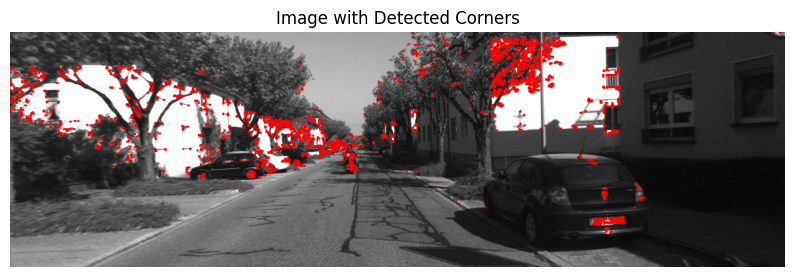

In [118]:
input_image_path = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\images\\000001.png'
output_image_path = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\Patch Tamplet\\000001_hc.png'

image = cv2.imread(input_image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_image = np.float32(gray_image)

# Perform Harris corner detection
corners = cv2.cornerHarris(gray_image, blockSize=2, ksize=3, k=0.06)

# Dilate the result to enhance corner points
corners = cv2.dilate(corners, None)
print(corners)

# Mark corners in red on the original image
image[corners > 0.01 * corners.max()] = [0, 0, 255]

# Convert BGR to RGB for correct color display in Matplotlib
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image with detected corners
plt.figure(figsize=(10, 10))  # Adjust size as needed
plt.imshow(rgb_image)
plt.axis('off')  # Hide axis
plt.title('Image with Detected Corners')

# Save and show the image
plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()